In [ ]:
import numpy as np
import math
from itertools import combinations_with_replacement
from scipy.signal import butter, lfilter, windows
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting module
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import rfft,rfftfreq
from scipy.signal import find_peaks
!pip install adjustText
from adjustText import adjust_text

plt.rcParams.update({
    'font.size': 18,
    'figure.figsize': (5, 5),
    'figure.dpi': 300
})

In [ ]:
# Import data from google drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')

data = pd.read_csv('/content/drive/MyDrive/NewSteppedSweep_340_380_120s.csv')
array = data.values
# remove ' sec' from first column and make it numerical data
array[:, 0] = [x.replace(' sec', '') for x in array[:, 0]]
array = array.astype(float)

Mounted at /content/drive


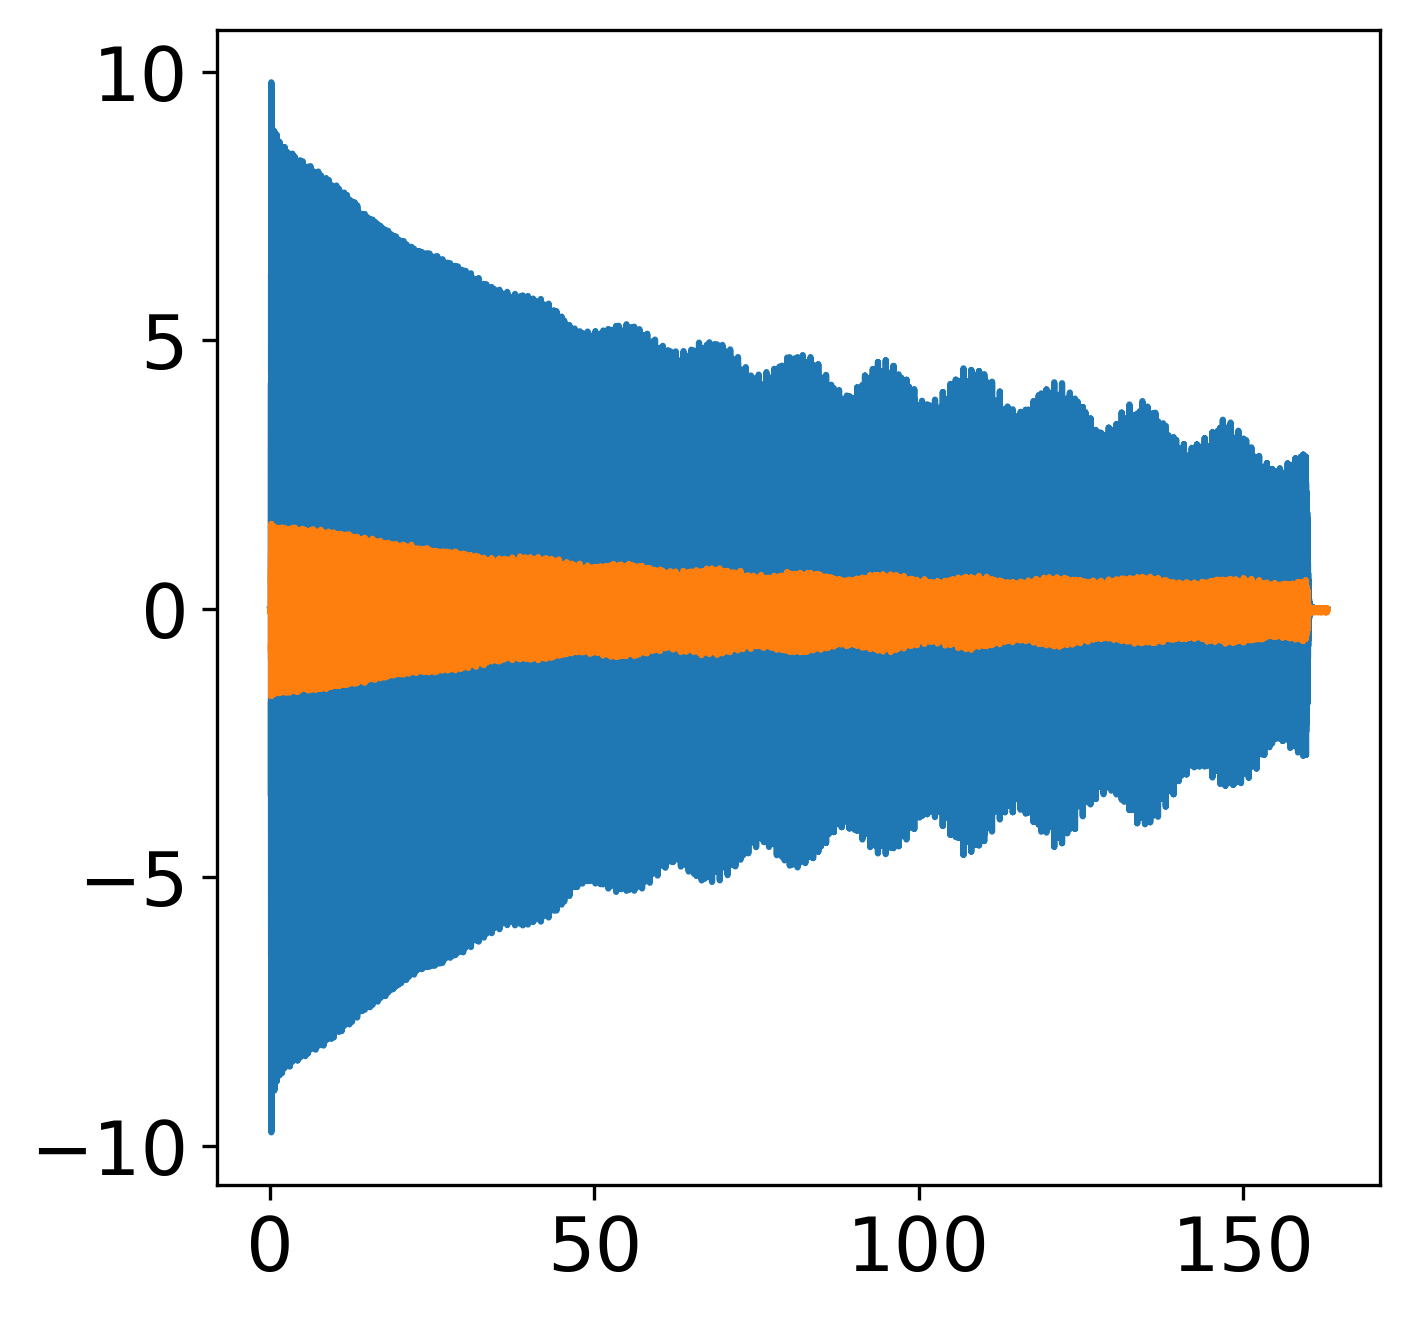

<class 'numpy.ndarray'> float64


In [ ]:
index = np.argmax(np.abs(array[:,1]) > 0.02)
array_cut = array[index-512:(index+5121*180),:]

array_cut[:, 0] = array_cut[:, 0] - array_cut[0,0]

plt.figure()
plt.plot(array_cut[:,0], array_cut[:,1])
plt.plot(array_cut[:,0], array_cut[:,2])
plt.show()

print(type(array_cut[:, 1]), array_cut[:, 1].dtype)


In [ ]:
amplitude = 1
sample_rate = 5121

freqs = np.concatenate([np.arange(340, 380, 0.1)])

duration_per_freq = 0.4  # Duration for each frequency in seconds
duration = 0.4*len(freqs)
print('Duration:', duration, 's')

wave = np.zeros(0) # Initialize an empty wave
for freq in freqs:

    signal_duration = math.floor(0.3*freq)/freq  # Duration of the pause in seconds
    pause_duration = duration_per_freq - signal_duration  # Duration of the sine wave

    # Pause
    pause_samples = int(pause_duration * sample_rate)
    pause_wave = np.zeros(pause_samples)

    # Signal
    signal_samples = int(signal_duration * sample_rate)
    time_array = np.linspace(0, signal_duration, signal_samples)
    sine_wave = amplitude * np.sin(2 * np.pi * freq * time_array)

    # Combine pause and signal
    freq_wave = np.concatenate([pause_wave, sine_wave])

    # Concatenate to the main wave
    wave = np.concatenate([wave, freq_wave])


Duration: 160.0 s


In [ ]:
duration_per_freq = 0.4  # Duration for each frequency in seconds
duration = 0.4*len(freqs)

sample_freq = 5121

a = 0
z = 0

FFTforce = []
FFTacc = []

for freq in freqs:

    signal_duration = math.floor(0.2*freq)/freq  # Duration of the signal in seconds
    pause_duration = duration_per_freq - signal_duration  # Duration of the sine wave

    pause_samples = int(pause_duration * sample_rate) # samples in the signal gen
    pause_duration_real = pause_samples/sample_rate # time in the signal gen
    pause_samples_exp = int(pause_duration_real * sample_freq) # samples in the data collected

    signal_samples = int(signal_duration * sample_rate) # samples in the signal gen
    signal_duration_real = signal_samples/sample_rate # time in the signal gen
    signal_samples_exp = int(signal_duration_real * sample_freq) # samples in the data collected

    # windows the active part of the signal for each frequency based on the signal itself
    a = z + int(pause_samples_exp)
    z = z + int(pause_samples_exp+signal_samples_exp)

    # length of the window in samples multiplied for interpolation but does not increase resolution
    # depends on the length of the signal duration
    n = len(array_cut[a:z,1])*100
    # resolution of f depends on n which depends on signal length
    # when the sample frequency is high, n samples is closer to a periodic signal so a frequency is close
    # to the desired freq, otherwise rounding causes the freqs in f to be rounded up or down
    f = np.fft.fftfreq(n, 1/sample_rate)
    f = f[:n//2]

    # comutes fft of the signal for one window
    fftforce = (np.fft.fft(array_cut[a:z,2], n=n))[:n//2]
    fftacc = (np.fft.fft(array_cut[a:z,1], n=n))[:n//2]
    # plt.figure()
    # plt.plot(f, np.abs(fftacc))
    # plt.plot(f, np.abs(fftforce))
    # plt.xlim(200, 600)
    index = np.argmin(np.abs(f - freq))  # Finds the closest match
    FFTforce.append(fftforce[index])
    FFTacc.append(fftacc[index])

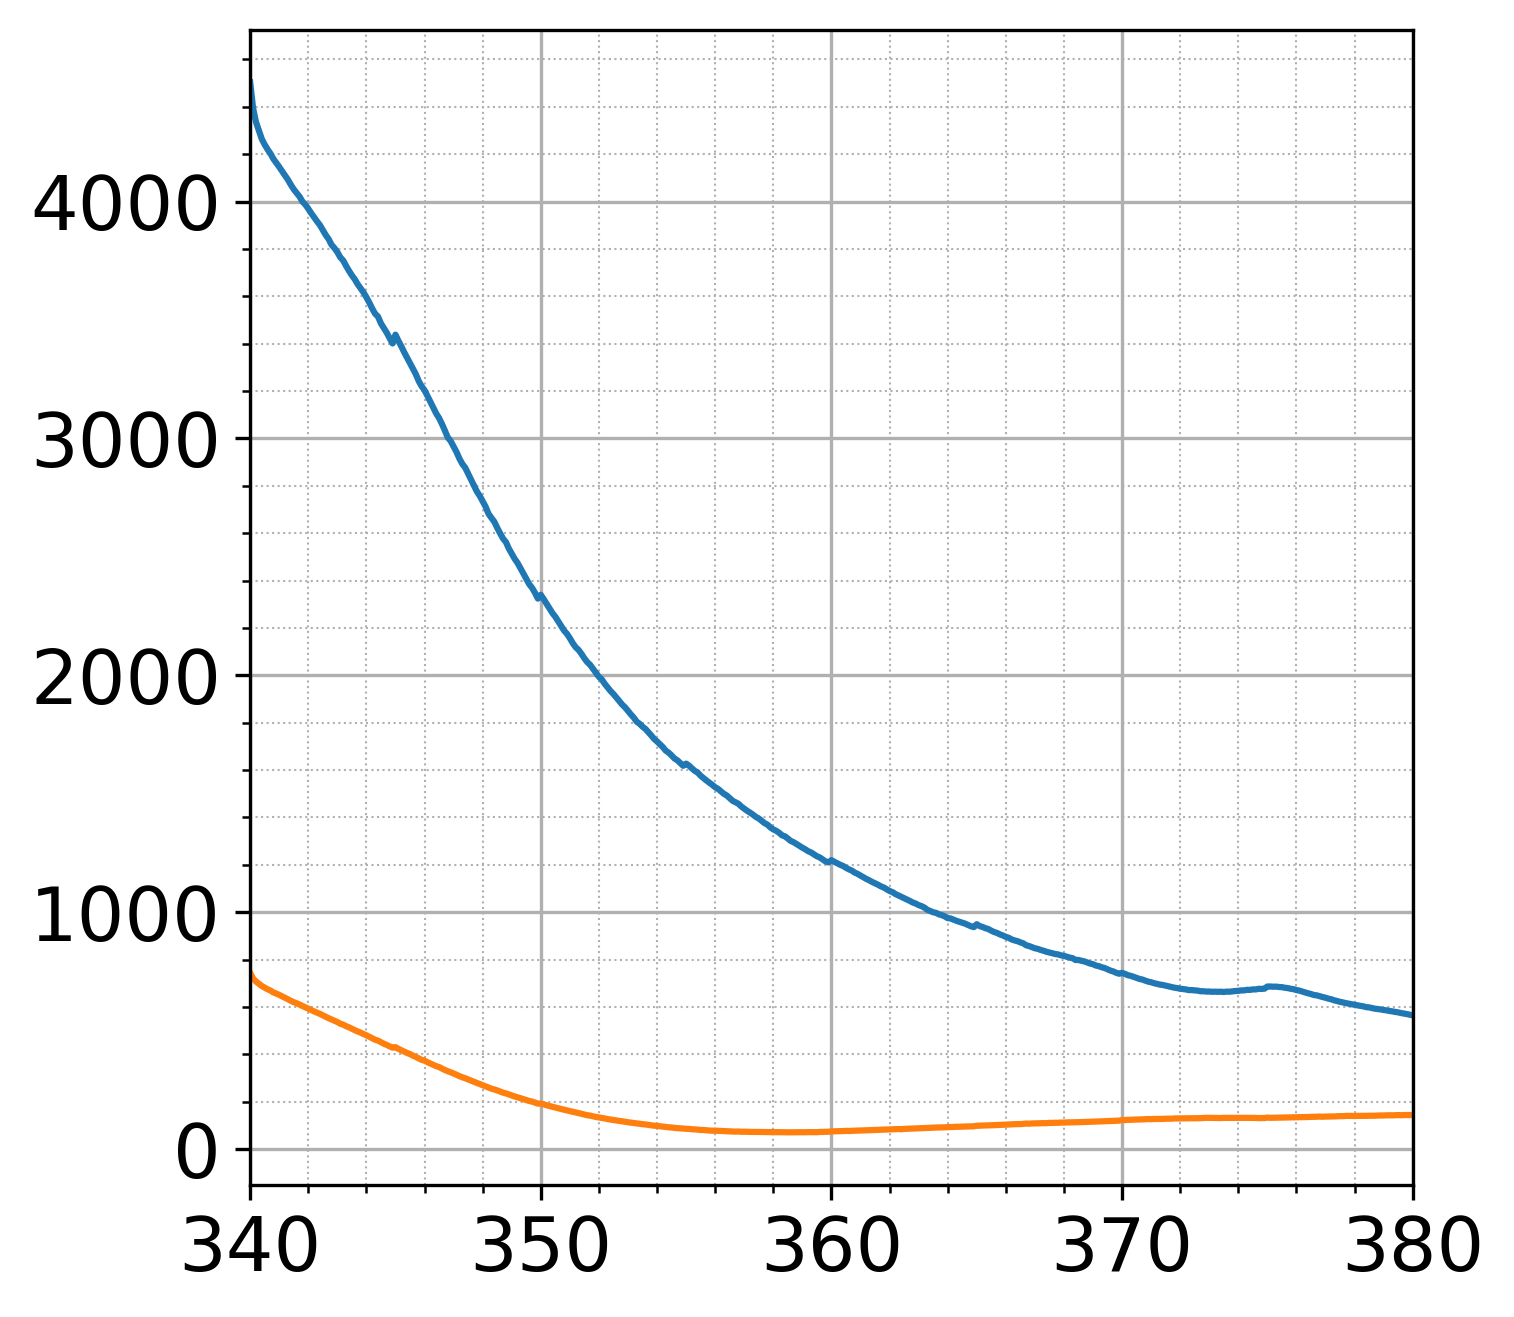

In [ ]:
plt.figure()
plt.plot(freqs, np.abs(FFTacc))
plt.plot(freqs, np.abs(FFTforce))
plt.xlim(340, 380)
# plt.ylim(70000, 77000)
plt.grid(True, which='major', linestyle='-', linewidth=0.8)  # Major grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)  # Minor grid
plt.minorticks_on()

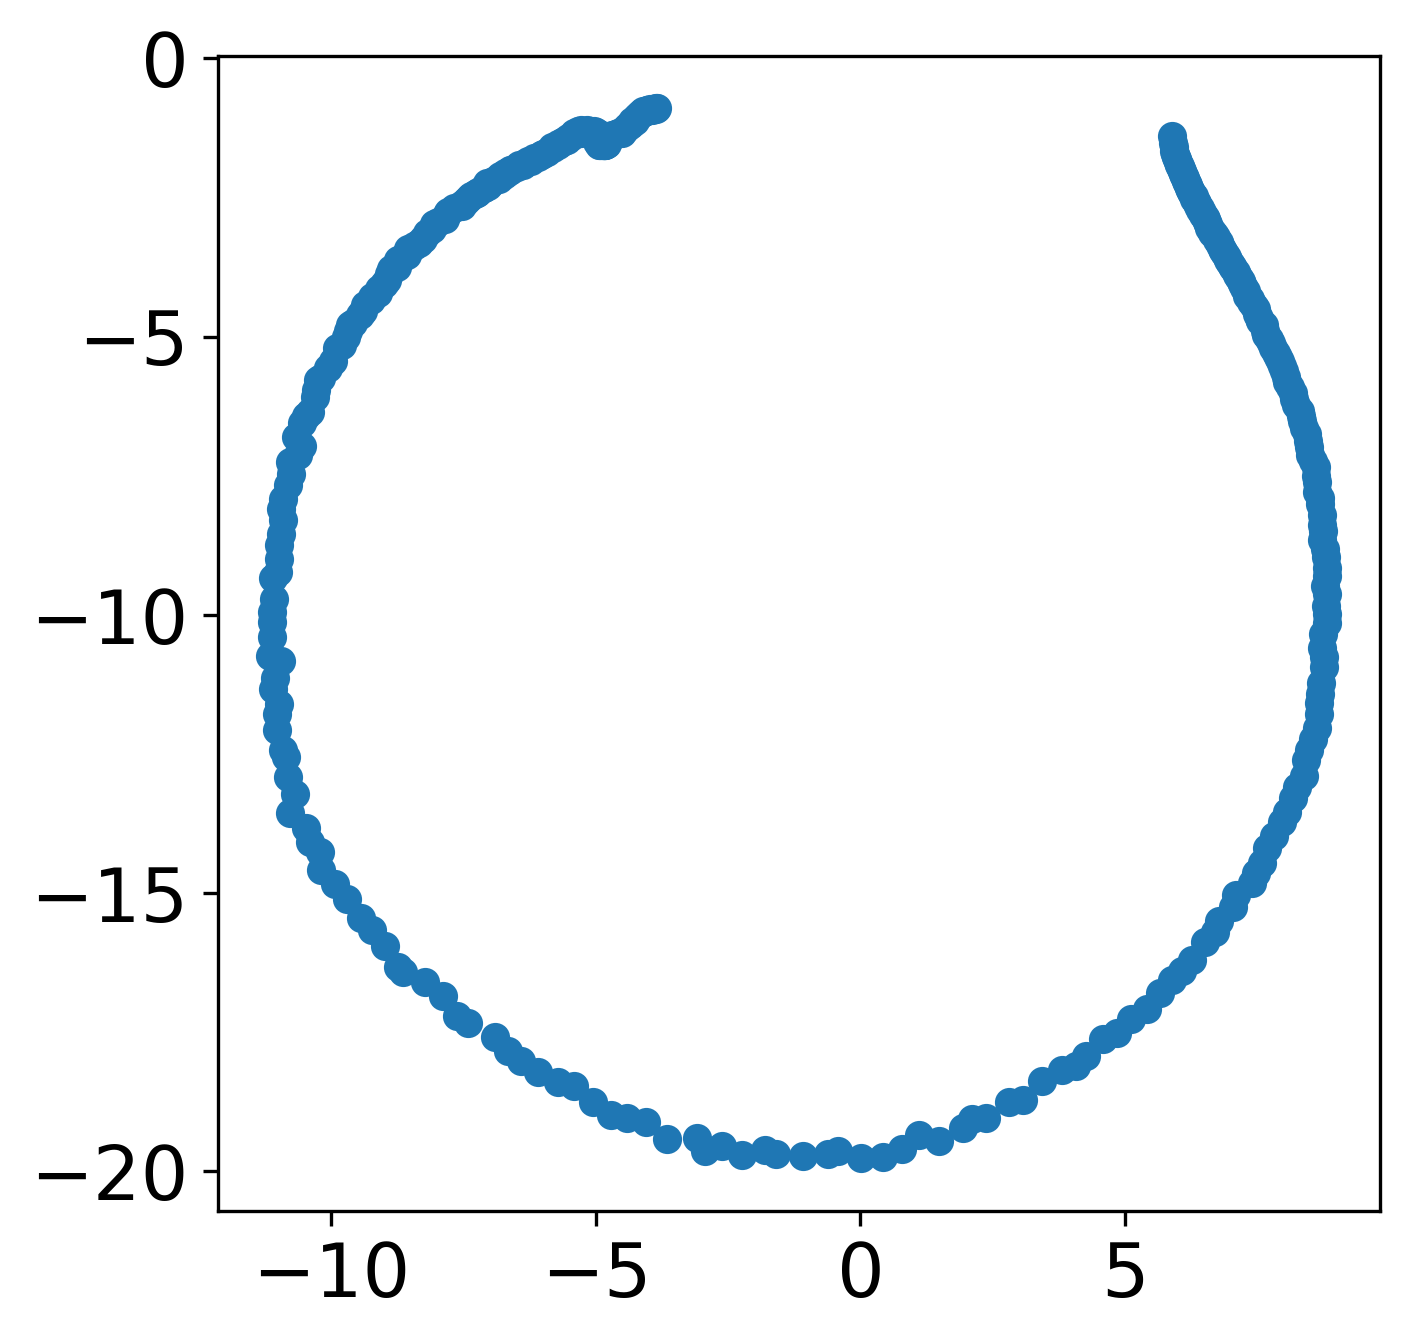

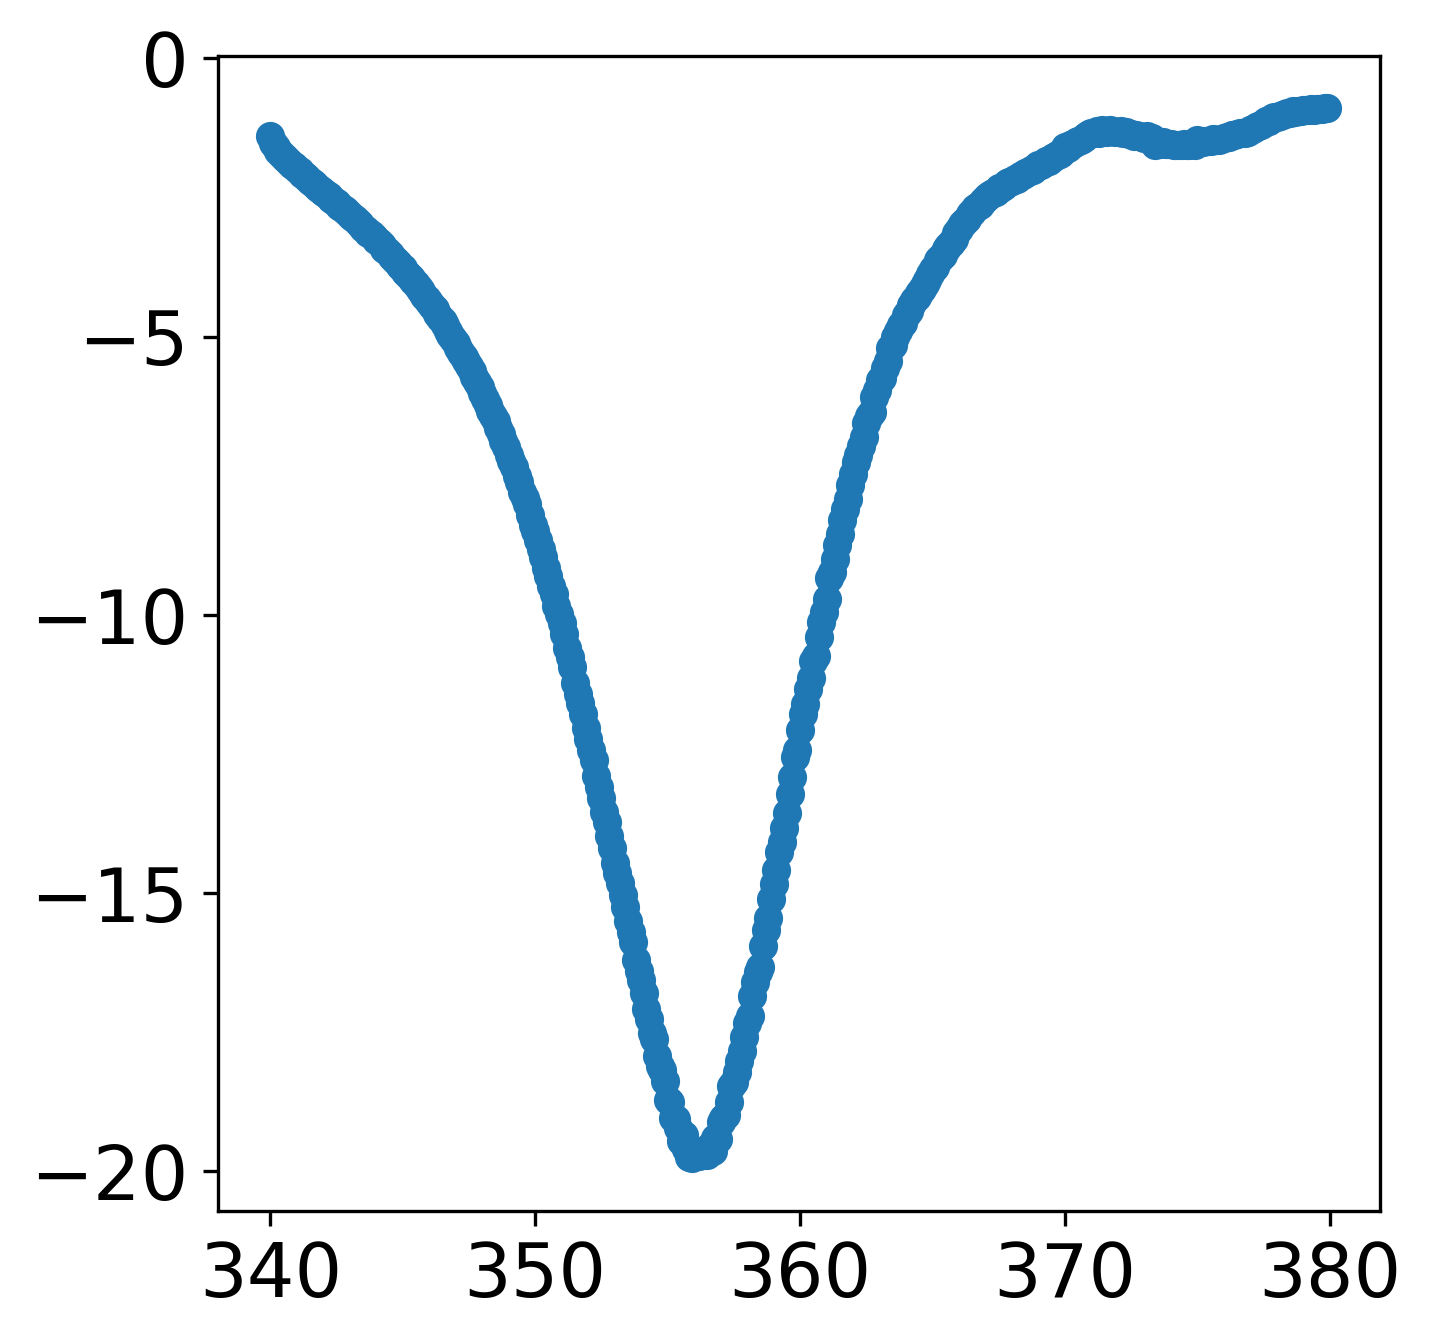

In [ ]:
# turn lists of FFT into numpy arrays
FFTacc = np.array(FFTacc)
FFTforce = np.array(FFTforce)
# calculate the FRF
frf = FFTacc/FFTforce
frfReal = np.real(frf)
frfImag = np.imag(frf)
# calculate the gain and phase

# plot the Nyquist
plt.figure()
plt.scatter(frfReal, frfImag)
plt.show()

# plot the imaginary
plt.figure()
plt.scatter(freqs, frfImag)
plt.show()

In [ ]:
frf_receptance = frf/-((freqs*2*np.pi)**2)  # Convert inertance to receptance
frf = frf_receptance
frfReal = np.real(frf)
frfImag = np.imag(frf)

In [ ]:
!pip install circle-fit
import numpy as np
from circle_fit import least_squares_circle

In [ ]:
xc, yc, r, residual = least_squares_circle(np.array([frfReal, frfImag]).T)

Text(0.02, 0.95, '(a)')

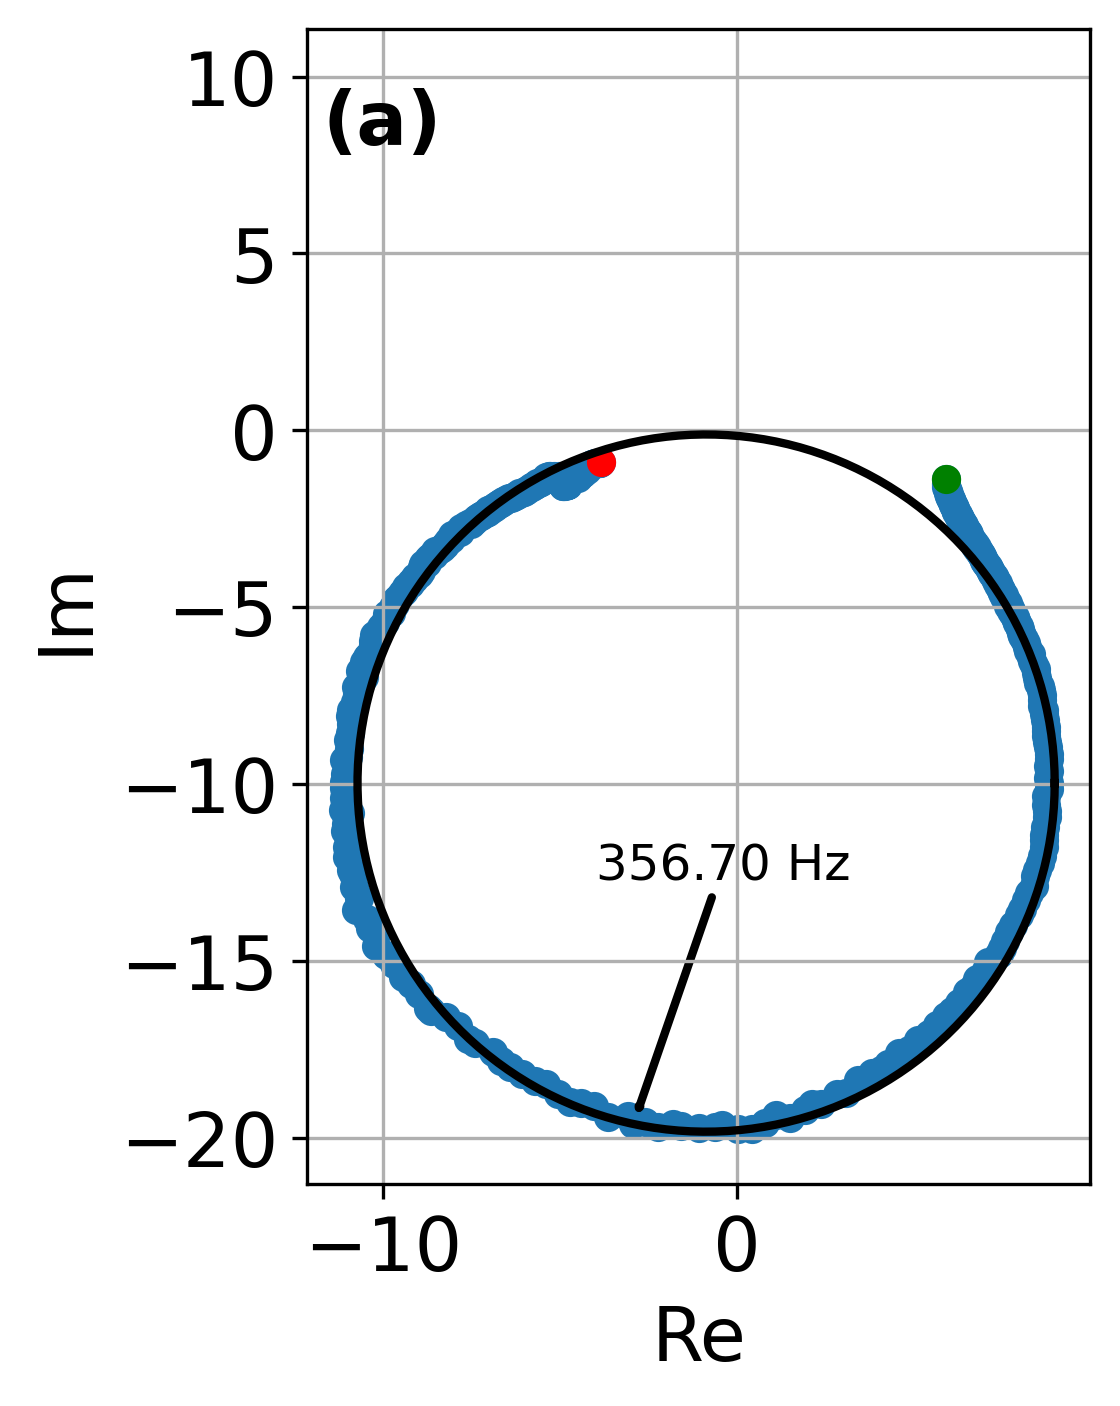

In [ ]:
# plot the Nyquist
plt.figure()
plt.scatter(frfReal, frfImag)
plt.xlabel('Re')
plt.ylabel('Im')
# plt.title('Nyquist plot')

plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Start and end points
plt.plot(frfReal[0], frfImag[0], 'go', label='Start')
plt.plot(frfReal[-1], frfImag[-1], 'ro', label='End')

# Annotate one key frequency (e.g., peak magnitude)
idx = np.argmax(np.abs(frf))
txt = plt.text(frfReal[idx], frfImag[idx]*0.65, f"{freqs[idx]:.2f} Hz", color='k', size=12)
adjust_text([txt], target_x=[frfReal[idx]], target_y=[frfImag[idx]],
            arrowprops=dict(arrowstyle="->", color='black', lw=2))

# Plot the fitted circle
theta_fit = np.linspace(0, 2*np.pi, 180)
x_fit = xc + r * np.cos(theta_fit)
y_fit = yc + r * np.sin(theta_fit)

plt.plot(x_fit, y_fit,r, color='k', linewidth=2)
ax = plt.gca()  # Get current axes
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes,
    fontsize=18, fontweight='bold', va='top', ha='left')

# Optional legend
# plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

Text(0.5, 0.92, 'Inertance Nyquist plot')

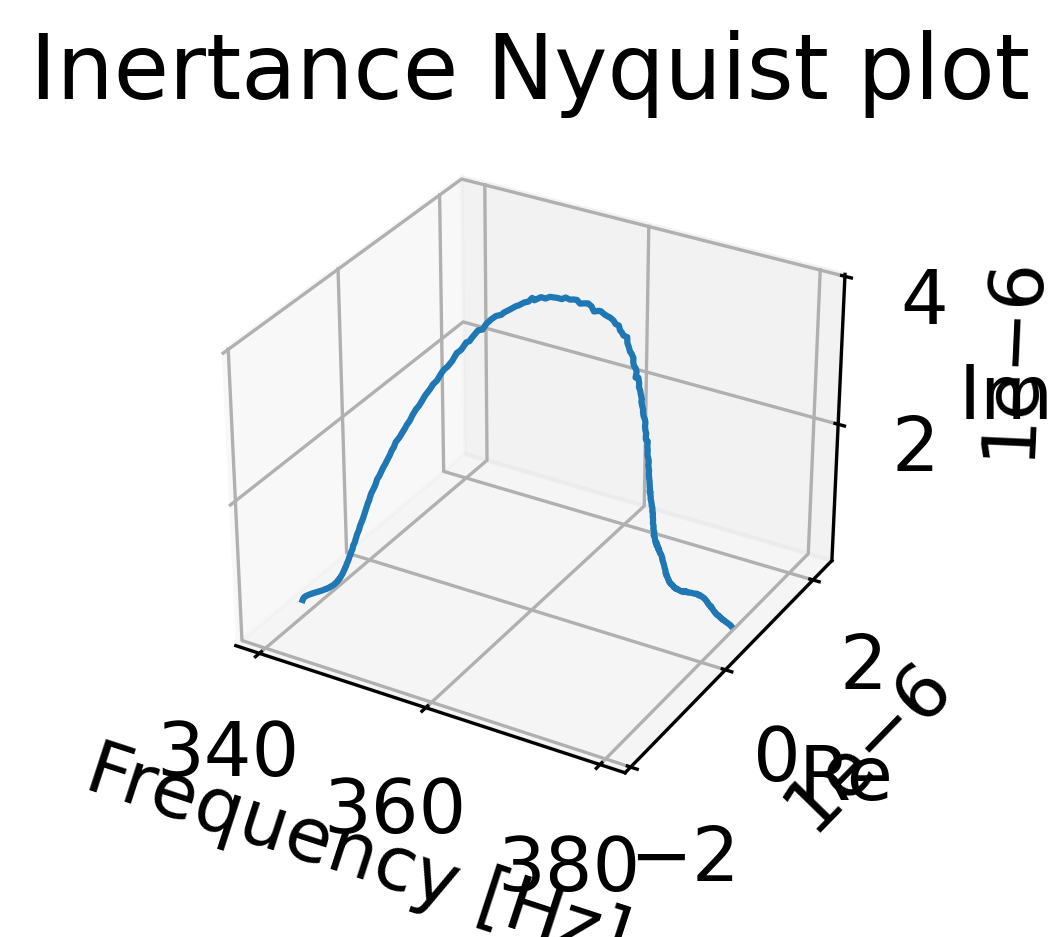

In [ ]:
fig = plt.figure()  # Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
ax.plot(freqs, frfReal, frfImag) #3d plot
ax.set_ylabel('Re') #3d plot
ax.set_zlabel('Im') #3d plot
ax.set_xlabel('Frequency [Hz]') #3d plot
ax.set_title('Inertance Nyquist plot') #3d plot

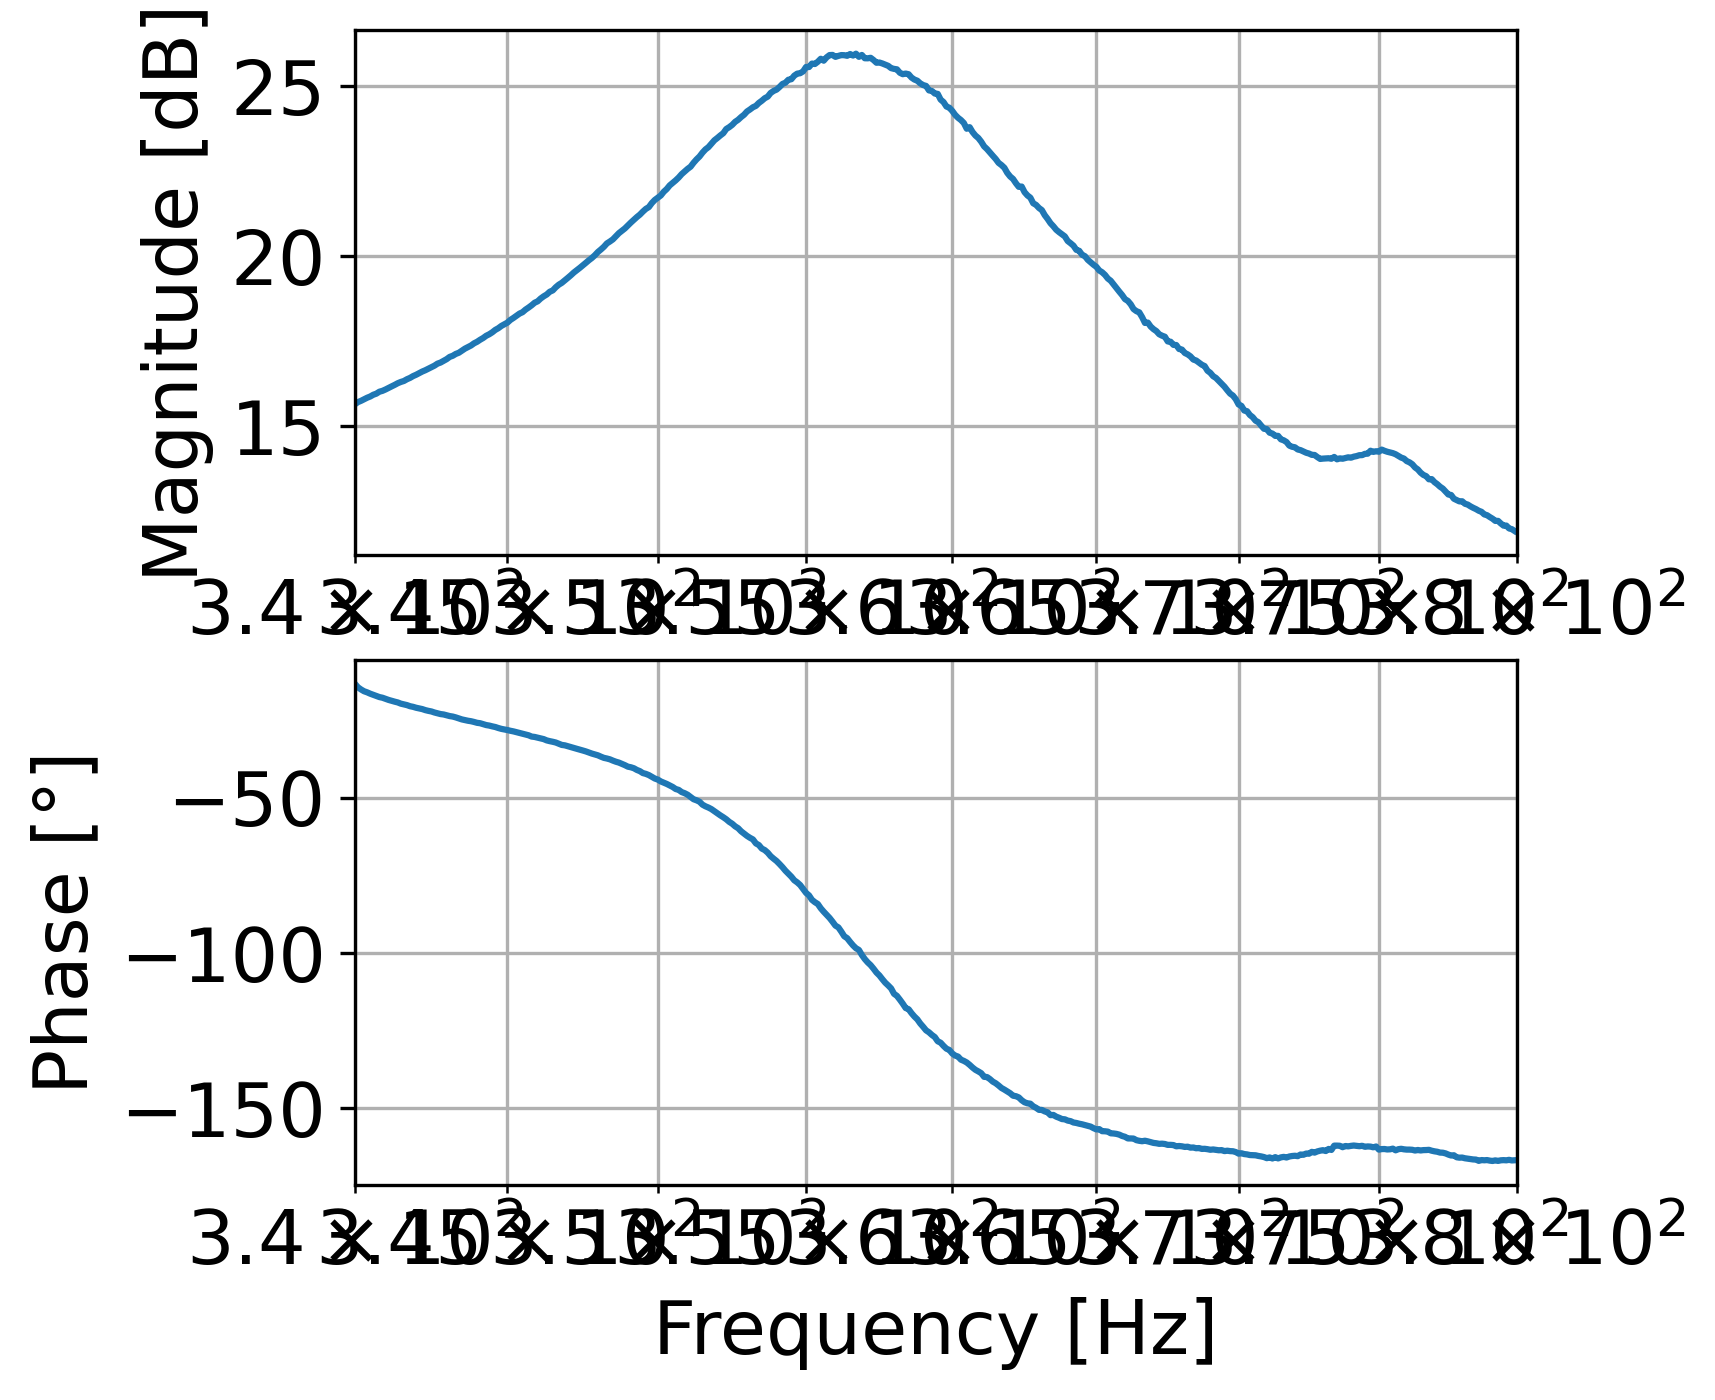

In [ ]:
# Compute Gain (Magnitude) and convert to dB
gain = np.abs(frf)
gain_dB = 20 * np.log10(gain)  # Convert magnitude to decibels

# Compute Phase in degrees
phase = np.angle(frf, deg=True)

# Define frequency axis (assuming you have `freqs` defined)
freqs = np.array(freqs)  # Ensure it's a NumPy array

# Magnitude Plot
plt.subplot(2, 1, 1)
plt.semilogx(freqs, gain_dB, label="Gain (dB)")
plt.xlim(340, 380)
plt.xlabel("Frequency (Hz)")
plt.ylabel('Magnitude [dB]')
plt.grid(True, which="both")

# Phase Plot
plt.subplot(2, 1, 2)
plt.semilogx(freqs, phase, label="Phase (degrees)")
plt.xlim(340, 380)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [°]')
plt.grid(True, which="both")